In [ ]:
import os
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from collections import Counter

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:

# ==========================================
# STEP 0: PARAMETERS & PATHS (sesuaikan)
# ==========================================
PROCESSED_DIR = "../dataset_processed"  # output: train/ val/ test/ per kelas
MODEL_DIR = "../models"
MODEL_ID = 1

IMG_SIZE = (224, 224)   # tuple: target_size untuk flow_from_directory
IMG_SIDE = IMG_SIZE[0]  # integer untuk fungsi make_square
BATCH_SIZE = 16

# Training
TRAIN_EPOCHS = 10
TRAIN_LEARNING_RATE = 0.0003

# Fine-Tuning
TUNING_EPOCHS = 5
TUNING_LEARNING_RATE =  0.0005

os.makedirs(MODEL_DIR, exist_ok=True)

PARAMETER siap: (224, 224) BATCH_SIZE= 16


In [12]:

# ==========================================
# STEP 4: Data generators
# - train: augmentation + rescale
# - val/test: hanya rescale
# ==========================================

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

valtest_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(PROCESSED_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
)

val_generator = valtest_datagen.flow_from_directory(
    os.path.join(PROCESSED_DIR, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = valtest_datagen.flow_from_directory(
    os.path.join(PROCESSED_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Generators siap:")
print(" - train samples:", train_generator.samples)
print(" - val samples:", val_generator.samples)
print(" - test samples:", test_generator.samples)
print("Classes:", train_generator.class_indices)


Found 1556 images belonging to 4 classes.
Found 193 images belonging to 4 classes.
Found 198 images belonging to 4 classes.
Generators siap:
 - train samples: 1556
 - val samples: 193
 - test samples: 198
Classes: {'alur': 0, 'lubang': 1, 'retak': 2, 'tidak_rusak': 3}


In [13]:

# ==========================================
# (Optional) print counts per class for sanity check
# ==========================================

print("\nCounts per class (train):")
train_counts = Counter([os.path.split(f)[0] for f in train_generator.filenames])
for cls, idx in train_generator.class_indices.items():
    print(f" - {cls}: {train_counts[cls]}")

print("\nCounts per class (val):")
val_counts = Counter([os.path.split(f)[0] for f in val_generator.filenames])
for cls, idx in val_generator.class_indices.items():
    print(f" - {cls}: {val_counts[cls]}")

print("\nCounts per class (test):")
val_counts = Counter([os.path.split(f)[0] for f in test_generator.filenames])
for cls, idx in val_generator.class_indices.items():
    print(f" - {cls}: {val_counts[cls]}")



Counts per class (train):
 - alur: 20
 - lubang: 812
 - retak: 668
 - tidak_rusak: 56

Counts per class (val):
 - alur: 2
 - lubang: 101
 - retak: 83
 - tidak_rusak: 7

Counts per class (test):
 - alur: 4
 - lubang: 102
 - retak: 85
 - tidak_rusak: 7


In [14]:

# ==========================================
# STEP 5: Build model (MobileNetV2 transfer learning)
# ==========================================

num_classes = train_generator.num_classes

MODEL_NAME = "MobileNetV2"
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIDE, IMG_SIDE, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
preds = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

# freeze base
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=TRAIN_LEARNING_RATE), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

print("\nModel siap. Jumlah kelas:", num_classes)



Model siap. Jumlah kelas: 4


In [15]:

# ==========================================
# STEP 6: Callbacks (recommended)
# ==========================================

checkpoint_path = os.path.join(MODEL_DIR, "best_model.h5")
callbacks = [
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]


In [16]:

# ==========================================
# STEP 7: Training
# ==========================================

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=TRAIN_EPOCHS,
    callbacks=callbacks
)



Epoch 1/10
98/98 [==============================] - ETA: 0s - loss: 0.6512 - accuracy: 0.7416
Epoch 1: val_loss improved from inf to 0.52498, saving model to ../model\best_model.h5
98/98 [==============================] - 53s 512ms/step - loss: 0.6512 - accuracy: 0.7416 - val_loss: 0.5250 - val_accuracy: 0.8549 - lr: 3.0000e-04
Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 0.4384 - accuracy: 0.8503
Epoch 2: val_loss improved from 0.52498 to 0.38142, saving model to ../model\best_model.h5
98/98 [==============================] - 30s 306ms/step - loss: 0.4384 - accuracy: 0.8503 - val_loss: 0.3814 - val_accuracy: 0.8808 - lr: 3.0000e-04
Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 0.3565 - accuracy: 0.8785
Epoch 3: val_loss improved from 0.38142 to 0.34365, saving model to ../model\best_model.h5
98/98 [==============================] - 31s 316ms/step - loss: 0.3565 - accuracy: 0.8785 - val_loss: 0.3436 - val_accuracy: 0.8912 - lr: 3.0000e-04
Ep

In [17]:
# ==========================================
# STEP 8: Fine-tuning (fase kedua)
# ==========================================

# Unfreeze 50 layer terakhir dari base model
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Compile ulang dengan learning rate lebih kecil
model.compile(
    optimizer=Adam(learning_rate=TUNING_LEARNING_RATE),  # LR kecil untuk fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Latih ulang model (fine-tuning)
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=TUNING_EPOCHS,
   callbacks=callbacks
)


Epoch 1/5
98/98 [==============================] - ETA: 0s - loss: 0.4293 - accuracy: 0.8689
Epoch 1: val_loss did not improve from 0.24738
98/98 [==============================] - 42s 380ms/step - loss: 0.4293 - accuracy: 0.8689 - val_loss: 0.3888 - val_accuracy: 0.9378 - lr: 5.0000e-04
Epoch 2/5
98/98 [==============================] - ETA: 0s - loss: 0.2285 - accuracy: 0.9248
Epoch 2: val_loss did not improve from 0.24738
98/98 [==============================] - 31s 313ms/step - loss: 0.2285 - accuracy: 0.9248 - val_loss: 1.8101 - val_accuracy: 0.7876 - lr: 5.0000e-04
Epoch 3/5
98/98 [==============================] - ETA: 0s - loss: 0.1467 - accuracy: 0.9473
Epoch 3: val_loss did not improve from 0.24738
98/98 [==============================] - 28s 291ms/step - loss: 0.1467 - accuracy: 0.9473 - val_loss: 2.2138 - val_accuracy: 0.7461 - lr: 5.0000e-04
Epoch 4/5
98/98 [==============================] - ETA: 0s - loss: 0.1809 - accuracy: 0.9460
Epoch 4: val_loss did not improve from 0

In [ ]:

# ==========================================
# STEP 8: Save final model & metadata
# ==========================================

# --- GABUNGKAN HISTORY (fase 1 + fase 2) ---
# agar grafik & statistik mencakup seluruh pelatihan
combined_history = {}
for key in history.history.keys():
    combined_history[key] = history.history[key] + history_finetune.history.get(key, [])

# --- Hitung rata-rata akurasi dari fase akhir (fine-tuning) ---
train_acc_avg = np.mean(history_finetune.history.get('accuracy', history.history.get('accuracy', [-1])))
val_acc_avg   = np.mean(history_finetune.history.get('val_accuracy', history.history.get('val_accuracy', [-1])))

train_acc_int = int(train_acc_avg * 100)
val_acc_int = int(val_acc_avg * 100)

# create versioned folder like before
pattern = re.compile(r"model-rdc-(\d+).(\d+)")
existing_dirs = [d for d in os.listdir(MODEL_DIR) if os.path.isdir(os.path.join(MODEL_DIR, d))]
model_id = MODEL_ID
versions = []
for d in existing_dirs:
    m = pattern.match(d)
    if m and int(m.group(1)) == model_id:
        versions.append(int(m.group(2)))
next_version = max(versions) + 1 if versions else 1

# --- Buat folder penyimpanan baru ---
model_fname = f"model-rdc-{model_id}.{next_version}"
save_dir = os.path.join(MODEL_DIR, model_fname)
os.makedirs(save_dir, exist_ok=True)

# --- Simpan model final (setelah fine-tuning) ---
final_model_path = os.path.join(save_dir, f"model.h5")
model.save(final_model_path)

# --- Simpan label kelas ---
labels = {v: k for k, v in train_generator.class_indices.items()}
with open(os.path.join(save_dir, "labels.json"), "w") as f:
    json.dump(labels, f, indent=4)

# --- Simpan ringkasan metadata model ---
summary = {
    "model_id": model_id,
    "version": next_version,
    "model_name": model_fname,
    "model_use": MODEL_NAME,
    "train_acc_avg": round(float(train_acc_avg) * 100, 2),
    "val_acc_avg": round(float(val_acc_avg) * 100, 2),
    "epochs_phase1": len(history.history.get('accuracy', [])),
    "epochs_phase2": len(history_finetune.history.get('accuracy', [])),
    "model_path": final_model_path
}
with open(os.path.join(save_dir, "summary.json"), "w") as f:
    json.dump(summary, f, indent=4)

def to_serializable(obj):
    """Konversi semua numpy type ke tipe Python biasa agar bisa di-dump ke JSON"""
    if isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    if isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    if isinstance(obj, (np.ndarray, list)):
        return [to_serializable(x) for x in obj]
    if isinstance(obj, dict):
        return {k: to_serializable(v) for k, v in obj.items()}
    return obj


# --- Simpan riwayat pelatihan (fase 1, fase 2, dan gabungan) ---
with open(os.path.join(save_dir, "history_phase1.json"), "w") as f:
    json.dump(to_serializable(history.history), f, indent=4)

with open(os.path.join(save_dir, "history_finetune.json"), "w") as f:
    json.dump(to_serializable(history_finetune.history), f, indent=4)

with open(os.path.join(save_dir, "history_combined.json"), "w") as f:
    json.dump(to_serializable(combined_history), f, indent=4)


print(f"📁 Semua file metadata dan history disimpan di: {save_dir}")


📁 Semua file metadata dan history disimpan di: ../model\model2-1-93-86


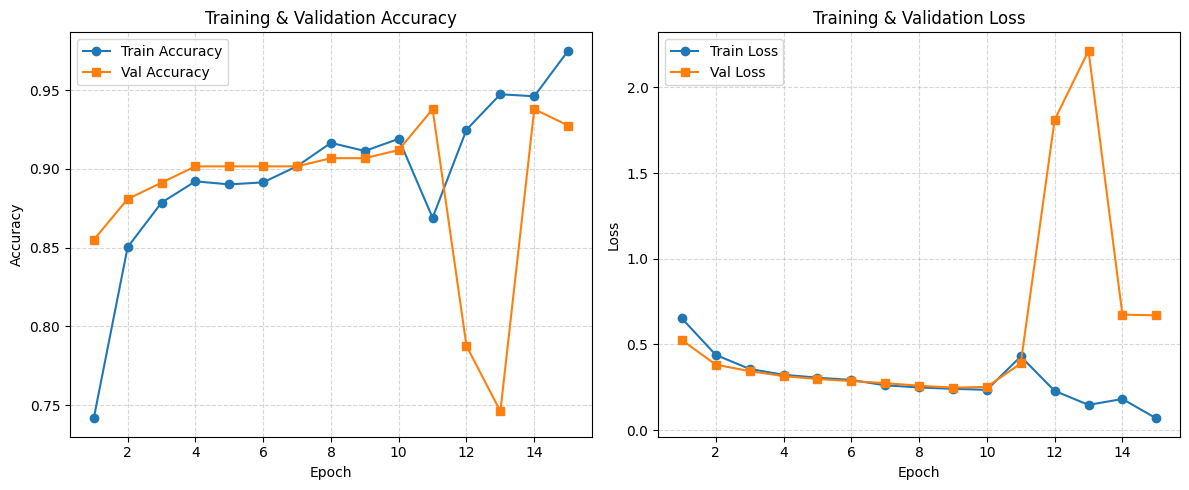

📈 Grafik akurasi & loss disimpan di: ../model\model2-1-93-86\metrics.png


In [19]:
# ==========================================
# STEP 9: Plot & save metrics (FINAL)
# ==========================================

# Gunakan combined_history dari STEP 8
acc      = combined_history.get('accuracy', [])
val_acc  = combined_history.get('val_accuracy', [])
loss     = combined_history.get('loss', [])
val_loss = combined_history.get('val_loss', [])

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# --- Plot Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Val Accuracy', marker='s')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# --- Plot Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Val Loss', marker='s')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

# --- Simpan grafik ---
metrics_path = os.path.join(save_dir, "metrics.png")
plt.savefig(metrics_path)
plt.show()
plt.close()

print(f"📈 Grafik akurasi & loss disimpan di: {metrics_path}")



🚀 Evaluasi Model pada Validation Set...

📊 Classification Report (Validation):
              precision    recall  f1-score   support

        alur       0.00      0.00      0.00         2
      lubang       0.99      0.90      0.94       101
       retak       0.87      0.99      0.93        83
 tidak_rusak       0.86      0.86      0.86         7

    accuracy                           0.93       193
   macro avg       0.68      0.69      0.68       193
weighted avg       0.92      0.93      0.92       193

✅ Laporan evaluasi validasi disimpan: ../model\model2-1-93-86\evaluation_val.json


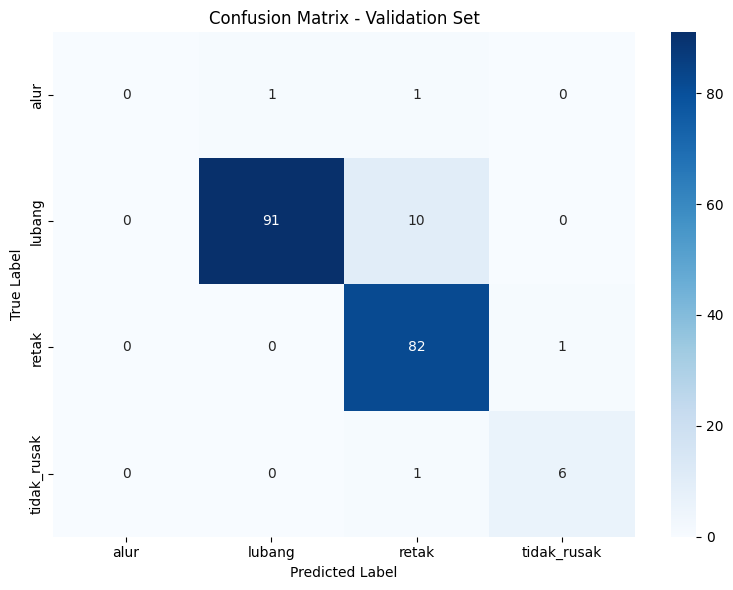

🧩 Confusion matrix validasi disimpan di: ../model\model2-1-93-86\confusion_matrix_val.png


In [20]:

# ==========================================
# STEP 10: Evaluation (validation set)
# ==========================================
print("\n🚀 Evaluasi Model pada Validation Set...")

# --- Reset generator agar prediksi berurutan ---
val_generator.reset()

# --- Prediksi ---
y_pred = model.predict(val_generator, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# --- Label kelas ---
class_labels = list(val_generator.class_indices.keys())

# --- Classification Report ---
print("\n📊 Classification Report (Validation):")
report_val = classification_report(
    y_true,
    y_pred_classes,
    target_names=class_labels,
    zero_division=0,
    output_dict=True
)
print(classification_report(
    y_true,
    y_pred_classes,
    target_names=class_labels,
    zero_division=0
))

# --- Simpan laporan evaluasi ke JSON ---
eval_val_path = os.path.join(save_dir, "evaluation_val.json")
with open(eval_val_path, "w") as f:
    json.dump(report_val, f, indent=4)
print(f"✅ Laporan evaluasi validasi disimpan: {eval_val_path}")

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')

# --- Simpan confusion matrix ---
cm_val_path = os.path.join(save_dir, "confusion_matrix_val.png")
plt.tight_layout()
plt.savefig(cm_val_path)
plt.show()
plt.close()

print(f"🧩 Confusion matrix validasi disimpan di: {cm_val_path}")


🚀 Evaluasi Model pada Test Set...

📈 Test Accuracy: 92.42%  |  Test Loss: 0.6040

📊 Classification Report (Test):
              precision    recall  f1-score   support

        alur       0.00      0.00      0.00         4
      lubang       0.99      0.93      0.96       102
       retak       0.87      0.99      0.92        85
 tidak_rusak       0.80      0.57      0.67         7

    accuracy                           0.92       198
   macro avg       0.66      0.62      0.64       198
weighted avg       0.91      0.92      0.91       198

✅ Laporan evaluasi testing disimpan: ../model\model2-1-93-86\evaluation_test.json


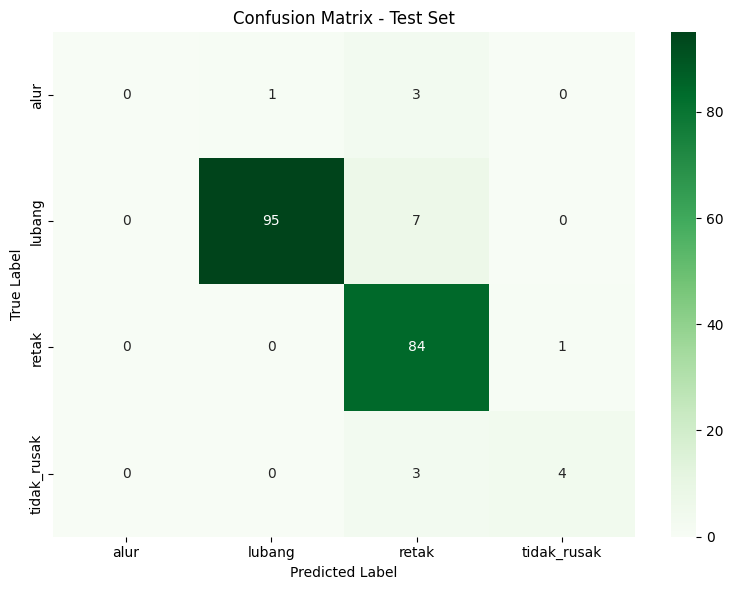

🧩 Confusion matrix testing disimpan di: ../model\model2-1-93-86\confusion_matrix_test.png
📘 Summary diperbarui dengan hasil test: ../model\model2-1-93-86\summary.json


In [21]:

# ==========================================
# STEP 11: Testing (test set)
# ==========================================
print("\n🚀 Evaluasi Model pada Test Set...")

# --- Reset generator ---
test_generator.reset()

# --- Evaluasi langsung ---
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"\n📈 Test Accuracy: {test_acc*100:.2f}%  |  Test Loss: {test_loss:.4f}")

# --- Prediksi ---
y_pred_test = model.predict(test_generator, verbose=0)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_true_test = test_generator.classes

# --- Label kelas ---
class_labels = list(test_generator.class_indices.keys())

# --- Classification Report ---
print("\n📊 Classification Report (Test):")
report_test = classification_report(
    y_true_test,
    y_pred_test_classes,
    target_names=class_labels,
    zero_division=0,
    output_dict=True
)
print(classification_report(
    y_true_test,
    y_pred_test_classes,
    target_names=class_labels,
    zero_division=0
))

# --- Simpan laporan evaluasi ke JSON ---
eval_test_path = os.path.join(save_dir, "evaluation_test.json")
with open(eval_test_path, "w") as f:
    json.dump(report_test, f, indent=4)
print(f"✅ Laporan evaluasi testing disimpan: {eval_test_path}")

# --- Confusion Matrix ---
cm_test = confusion_matrix(y_true_test, y_pred_test_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')

# --- Simpan confusion matrix ---
cm_test_path = os.path.join(save_dir, "confusion_matrix_test.png")
plt.tight_layout()
plt.savefig(cm_test_path)
plt.show()
plt.close()

print(f"🧩 Confusion matrix testing disimpan di: {cm_test_path}")

# --- Simpan ringkasan hasil test ke summary.json ---
summary["test_accuracy"] = round(float(test_acc) * 100, 2)
summary["test_loss"] = round(float(test_loss), 4)

with open(os.path.join(save_dir, "summary.json"), "w") as f:
    json.dump(summary, f, indent=4)

print(f"📘 Summary diperbarui dengan hasil test: {os.path.join(save_dir, 'summary.json')}")
